# Code to change

In [124]:
#text prompt
text_promt = 'pink vertical striped pants'

#model paths
elrm_model_path = '../region_generation_epoch60.pth' 
styleswap_model_path = '../fashion-model-finetuned_full'
output_path = 'example_output2.png'
img_path = '../resized_ash.png'


# Model stuff

##### cross_entropy_loss

In [2]:
def accuracy(pred, target, topk=1, thresh=None):
    """Calculate accuracy according to the prediction and target.

    Args:
        pred (torch.Tensor): The model prediction, shape (N, num_class, ...)
        target (torch.Tensor): The target of each prediction, shape (N, , ...)
        topk (int | tuple[int], optional): If the predictions in ``topk``
            matches the target, the predictions will be regarded as
            correct ones. Defaults to 1.
        thresh (float, optional): If not None, predictions with scores under
            this threshold are considered incorrect. Default to None.

    Returns:
        float | tuple[float]: If the input ``topk`` is a single integer,
            the function will return a single float as accuracy. If
            ``topk`` is a tuple containing multiple integers, the
            function will return a tuple containing accuracies of
            each ``topk`` number.
    """
    assert isinstance(topk, (int, tuple)) # topk should be int or tuple 
    if isinstance(topk, int):
        topk = (topk, )
        return_single = True
    else:
        return_single = False # convert topk to tuple if int, track how many values user passed

    maxk = max(topk) # max number of top predictions we'll evaluate
    if pred.size(0) == 0:
        accu = [pred.new_tensor(0.) for i in range(len(topk))]
        return accu[0] if return_single else accu # check if pred batch is empty
    assert pred.ndim == target.ndim + 1 # checks that pred has one more dimension than target
    assert pred.size(0) == target.size(0) # same size
    assert maxk <= pred.size(1), \
        f'maxk {maxk} exceeds pred dimension {pred.size(1)}'
    pred_value, pred_label = pred.topk(maxk, dim=1) # selects topk predictions and their indices
    # transpose to shape (maxk, N, ...)
    pred_label = pred_label.transpose(0, 1)
    correct = pred_label.eq(target.unsqueeze(0).expand_as(pred_label)) # makes correct a boolean matrix (whether top-k predictions match the target)
    if thresh is not None:
        # Only prediction values larger than thresh are counted as correct
        correct = correct & (pred_value > thresh).t() # masks out prediction below threshold with top-k scores
    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / target.numel()))
    return res[0] if return_single else res


#### Archs

In [3]:
# import libraries

import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
def reduce_loss(loss, reduction):
    """Reduce loss as specified.

    Args:
        loss (Tensor): Elementwise loss tensor.
        reduction (str): Options are "none", "mean" and "sum".

    Return:
        Tensor: Reduced loss tensor.
    """
    reduction_enum = F._Reduction.get_enum(reduction)
    # none: 0, elementwise_mean:1, sum: 2
    if reduction_enum == 0:
        return loss
    elif reduction_enum == 1:
        return loss.mean()
    elif reduction_enum == 2:
        return loss.sum()

In [5]:
def weight_reduce_loss(loss, weight=None, reduction='mean', avg_factor=None):
    """Apply element-wise weight and reduce loss.

    Args:
        loss (Tensor): Element-wise loss.
        weight (Tensor): Element-wise weights.
        reduction (str): Same as built-in losses of PyTorch.
        avg_factor (float): Avarage factor when computing the mean of losses.

    Returns:
        Tensor: Processed loss values.
    """
    # if weight is specified, apply element-wise weight
    if weight is not None:
        assert weight.dim() == loss.dim()
        if weight.dim() > 1:
            assert weight.size(1) == 1 or weight.size(1) == loss.size(1)
        loss = loss * weight

    # if avg_factor is not specified, just reduce the loss
    if avg_factor is None:
        loss = reduce_loss(loss, reduction)
    else:
        # if reduction is mean, then average the loss by avg_factor
        if reduction == 'mean':
            loss = loss.sum() / avg_factor
        # if reduction is 'none', then do nothing, otherwise raise an error
        elif reduction != 'none':
            raise ValueError('avg_factor can not be used with reduction="sum"')
    return loss

In [6]:
def cross_entropy(pred,
                  label,
                  weight=None,
                  class_weight=None,
                  reduction='mean',
                  avg_factor=None,
                  ignore_index=-100):
    """The wrapper function for :func:`F.cross_entropy`"""
    # class_weight is a manual rescaling weight given to each class.
    # If given, has to be a Tensor of size C element-wise losses
    loss = F.cross_entropy(
        pred,
        label,
        weight=class_weight,
        reduction='none',
        ignore_index=ignore_index)

    # apply weights and do the reduction
    if weight is not None:
        weight = weight.float()
    loss = weight_reduce_loss(
        loss, weight=weight, reduction=reduction, avg_factor=avg_factor)

    return loss

In [7]:
def _expand_onehot_labels(labels, label_weights, target_shape, ignore_index):
    """Expand onehot labels to match the size of prediction."""
    bin_labels = labels.new_zeros(target_shape)
    valid_mask = (labels >= 0) & (labels != ignore_index)
    inds = torch.nonzero(valid_mask, as_tuple=True)

    if inds[0].numel() > 0:
        if labels.dim() == 3:
            bin_labels[inds[0], labels[valid_mask], inds[1], inds[2]] = 1
        else:
            bin_labels[inds[0], labels[valid_mask]] = 1

    valid_mask = valid_mask.unsqueeze(1).expand(target_shape).float()
    if label_weights is None:
        bin_label_weights = valid_mask
    else:
        bin_label_weights = label_weights.unsqueeze(1).expand(target_shape)
        bin_label_weights *= valid_mask

    return bin_labels, bin_label_weights

In [8]:
def binary_cross_entropy(pred,
                         label,
                         weight=None,
                         reduction='mean',
                         avg_factor=None,
                         class_weight=None,
                         ignore_index=255):
    """Calculate the binary CrossEntropy loss.

    Args:
        pred (torch.Tensor): The prediction with shape (N, 1).
        label (torch.Tensor): The learning label of the prediction.
        weight (torch.Tensor, optional): Sample-wise loss weight.
        reduction (str, optional): The method used to reduce the loss.
            Options are "none", "mean" and "sum".
        avg_factor (int, optional): Average factor that is used to average
            the loss. Defaults to None.
        class_weight (list[float], optional): The weight for each class.
        ignore_index (int | None): The label index to be ignored. Default: 255

    Returns:
        torch.Tensor: The calculated loss
    """
    if pred.dim() != label.dim():
        assert (pred.dim() == 2 and label.dim() == 1) or (
                pred.dim() == 4 and label.dim() == 3), \
            'Only pred shape [N, C], label shape [N] or pred shape [N, C, ' \
            'H, W], label shape [N, H, W] are supported'
        label, weight = _expand_onehot_labels(label, weight, pred.shape,
                                              ignore_index)

    # weighted element-wise losses
    if weight is not None:
        weight = weight.float()
    loss = F.binary_cross_entropy_with_logits(
        pred, label.float(), pos_weight=class_weight, reduction='none')
    # do the reduction for the weighted loss
    loss = weight_reduce_loss(
        loss, weight, reduction=reduction, avg_factor=avg_factor)

    return loss

In [9]:
def mask_cross_entropy(pred,
                       target,
                       label,
                       reduction='mean',
                       avg_factor=None,
                       class_weight=None,
                       ignore_index=None):
    """Calculate the CrossEntropy loss for masks.

    Args:
        pred (torch.Tensor): The prediction with shape (N, C), C is the number
            of classes.
        target (torch.Tensor): The learning label of the prediction.
        label (torch.Tensor): ``label`` indicates the class label of the mask'
            corresponding object. This will be used to select the mask in the
            of the class which the object belongs to when the mask prediction
            if not class-agnostic.
        reduction (str, optional): The method used to reduce the loss.
            Options are "none", "mean" and "sum".
        avg_factor (int, optional): Average factor that is used to average
            the loss. Defaults to None.
        class_weight (list[float], optional): The weight for each class.
        ignore_index (None): Placeholder, to be consistent with other loss.
            Default: None.

    Returns:
        torch.Tensor: The calculated loss
    """
    assert ignore_index is None, 'BCE loss does not support ignore_index'
    # TODO: handle these two reserved arguments
    assert reduction == 'mean' and avg_factor is None
    num_rois = pred.size()[0]
    inds = torch.arange(0, num_rois, dtype=torch.long, device=pred.device)
    pred_slice = pred[inds, label].squeeze(1)
    return F.binary_cross_entropy_with_logits(
        pred_slice, target, weight=class_weight, reduction='mean')[None]

In [10]:
class CrossEntropyLoss(nn.Module):
    """CrossEntropyLoss.

    Args:
        use_sigmoid (bool, optional): Whether the prediction uses sigmoid
            of softmax. Defaults to False.
        use_mask (bool, optional): Whether to use mask cross entropy loss.
            Defaults to False.
        reduction (str, optional): . Defaults to 'mean'.
            Options are "none", "mean" and "sum".
        class_weight (list[float], optional): Weight of each class.
            Defaults to None.
        loss_weight (float, optional): Weight of the loss. Defaults to 1.0.
    """

    def __init__(self,
                 use_sigmoid=False,
                 use_mask=False,
                 reduction='mean',
                 class_weight=None,
                 loss_weight=1.0):
        super(CrossEntropyLoss, self).__init__()
        assert (use_sigmoid is False) or (use_mask is False)
        self.use_sigmoid = use_sigmoid
        self.use_mask = use_mask
        self.reduction = reduction
        self.loss_weight = loss_weight
        self.class_weight = class_weight

        if self.use_sigmoid:
            self.cls_criterion = binary_cross_entropy
        elif self.use_mask:
            self.cls_criterion = mask_cross_entropy
        else:
            self.cls_criterion = cross_entropy

    def forward(self,
                cls_score,
                label,
                weight=None,
                avg_factor=None,
                reduction_override=None,
                **kwargs):
        """Forward function."""
        assert reduction_override in (None, 'none', 'mean', 'sum')
        reduction = (
            reduction_override if reduction_override else self.reduction)
        if self.class_weight is not None:
            class_weight = cls_score.new_tensor(self.class_weight)
        else:
            class_weight = None
        loss_cls = self.loss_weight * self.cls_criterion(
            cls_score,
            label,
            weight,
            class_weight=class_weight,
            reduction=reduction,
            avg_factor=avg_factor,
            **kwargs)
        return loss_cls

## UNET

In [11]:
# unet arch

import torch
import torch.nn as nn
import torch.utils.checkpoint as cp
from mmcv.cnn import (ConvModule, build_activation_layer,
                      build_norm_layer, build_upsample_layer)
# from mmcv.runner import load_checkpoint
# from mmcv.utils.parrots_wrapper import _BatchNorm
# from mmseg.utils import get_root_logger
# UPSAMPLE_LAYERS, constant_init, kaiming_init

In [12]:
#unet_class
import torch
from mmcv.cnn import ConvModule, build_upsample_layer

class UpConvBlock(nn.Module):
    def __init__(self,
        conv_block,
        in_channels,
        skip_channels,
        out_channels,
        num_convs=2,
        stride=1,
        dilation=1,
        with_cp=False,
        conv_cfg=None,
        norm_cfg=dict(type='BN'),
        act_cfg=dict(type='ReLU'),
        upsample_cfg=dict(type='InterpConv'),
        dcn=None,
        plugins=None
        ):
        """Builds the upsample and conv blocks used in UNet decoder."""
        super(UpConvBlock, self).__init__()
        assert dcn is None, 'Not implemented yet.'
        assert plugins is None, 'Not implemented yet.'

        self.conv_block = conv_block(
            in_channels=2 * skip_channels,
            out_channels=out_channels,
            num_convs=num_convs,
            stride=stride,
            dilation=dilation,
            with_cp=with_cp,
            conv_cfg=conv_cfg,
            norm_cfg=norm_cfg,
            act_cfg=act_cfg,
            dcn=None,
            plugins=None
        )

        if upsample_cfg is not None:
            print(f"Building UpConvBlock with upsample_cfg: {upsample_cfg}")

            self.upsample = build_upsample_layer(
                cfg=upsample_cfg,
                in_channels=in_channels,
                out_channels=skip_channels,
                with_cp=with_cp,
                norm_cfg=norm_cfg,
                act_cfg=act_cfg
            )
            print(f"Upsample layer built: {self.upsample}")
        else:
            self.upsample = ConvModule(
                in_channels,
                skip_channels,
                kernel_size=1,
                stride=1,
                padding=0,
                conv_cfg=conv_cfg,
                norm_cfg=norm_cfg,
                act_cfg=act_cfg
            )

        

    def forward(self, skip, x):
        """Forward function for upsample + conv block."""
        x = self.upsample(x)
        out = torch.cat([skip, x], dim=1)
        out = self.conv_block(out)
        return out


In [13]:
import torch
import torch.nn as nn
import torch.utils.checkpoint as cp
from mmcv.cnn import ConvModule


class BasicConvBlock(nn.Module):
    def __init__(self,
        in_channels,
        out_channels,
        num_convs=2,
        stride=1,
        dilation=1,
        with_cp=False,
        conv_cfg=None,
        norm_cfg=dict(type='BN'),
        act_cfg=dict(type='ReLU'),
        dcn=None,
        plugins=None
        ):
        """
        Builds a basic convolutional block for UNet.

        This block consists of several plain convolutional layers (Conv + Norm + Activation).

        Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        num_convs (int): Number of convolutional layers. Default: 2.
        stride (int): If stride=2, applies stride convolution in the first layer. Default: 1.
        dilation (int): Dilation rate for all conv layers except the first. Default: 1.
        with_cp (bool): If True, enables checkpointing for memory savings. Default: False.
        conv_cfg (dict | None): Configuration for convolution layer. Default: None.
        norm_cfg (dict | None): Configuration for normalization layer. Default: dict(type='BN').
        act_cfg (dict | None): Configuration for activation function. Default: dict(type='ReLU').
        dcn (bool): Deformable convolution support. Not implemented. Default: None.
        plugins (dict): Plugins for conv layers. Not implemented. Default: None.

        Returns:
        nn.Sequential: A sequential module containing the convolutional layers.
        bool: Whether checkpointing is enabled.
        """

        super(BasicConvBlock, self).__init__()
        assert dcn is None, 'Not implemented yet.'
        assert plugins is None, 'Not implemented yet.'
        
        self.with_cp = with_cp
        convs = []
        for i in range(num_convs):
            convs.append(
                ConvModule(
                    in_channels=in_channels if i == 0 else out_channels,
                    out_channels=out_channels,
                    kernel_size=3,
                    stride=stride if i == 0 else 1,
                    dilation=1 if i == 0 else dilation,
                    padding=1 if i == 0 else dilation,
                    conv_cfg=conv_cfg,
                    norm_cfg=norm_cfg,
                    act_cfg=act_cfg
                )
            )

        self.convs = nn.Sequential(*convs)


    def forward(self, x):
        """
        Forward function for basic convolutional block.

        Args:
            x (Tensor): Input tensor.
            convs (nn.Sequential): Convolutional layers.
            with_cp (bool): Whether checkpointing is enabled.

        Returns:
            Tensor: Output tensor after applying convs.
        """
        if self.with_cp and x.requires_grad:
            out = cp.checkpoint(self.convs, x)
        else:
            out = self.convs(x)
        return out


In [14]:
from mmcv.cnn import UPSAMPLE_LAYERS, ConvModule
import torch.nn as nn
import torch.utils.checkpoint as cp

if 'InterpConv' not in UPSAMPLE_LAYERS:
    @UPSAMPLE_LAYERS.register_module()
    class InterpConv(nn.Module):
        """Interpolation upsample module in decoder for UNet.

        This module uses interpolation to upsample feature maps in the decoder
        of UNet. It consists of one interpolation upsample layer and one
        convolutional layer.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            with_cp (bool): Use checkpoint or not. Default: False.
            norm_cfg (dict): Config dict for normalization layer. Default: dict(type='BN').
            act_cfg (dict): Config dict for activation layer. Default: dict(type='ReLU').
            conv_cfg (dict | None): Config dict for convolution layer. Default: None.
            conv_first (bool): Whether convolutional layer or interpolation
                upsample layer comes first. Default: False.
            kernel_size (int): Kernel size of the convolutional layer. Default: 1.
            stride (int): Stride of the convolutional layer. Default: 1.
            padding (int): Padding of the convolutional layer. Default: 0.
            upsample_cfg (dict): Interpolation config of the upsample layer.
                Default: dict(scale_factor=2, mode='bilinear', align_corners=False).
        """

        def __init__(self,
                     in_channels,
                     out_channels,
                     with_cp=False,
                     norm_cfg=dict(type='BN'),
                     act_cfg=dict(type='ReLU'),
                     *,
                     conv_cfg=None,
                     conv_first=False,
                     kernel_size=1,
                     stride=1,
                     padding=0,
                     upsample_cfg=dict(scale_factor=2, mode='bilinear', align_corners=False)):
            super().__init__()  # Correctly initialize the parent class

            self.with_cp = with_cp
            print(f"Initializing InterpConv with in_channels={in_channels}, out_channels={out_channels}")

            # Convolutional layer
            conv = ConvModule(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                conv_cfg=conv_cfg,
                norm_cfg=norm_cfg,
                act_cfg=act_cfg
            )

            # Upsample layer
            upsample = nn.Upsample(**upsample_cfg)

            # Sequential order
            if conv_first:
                self.interp_upsample = nn.Sequential(conv, upsample)
            else:
                self.interp_upsample = nn.Sequential(upsample, conv)

        def forward(self, x):
            """Forward function."""
            print(f"InterpConv forward called with input shape: {x.shape}")
            if self.with_cp and x.requires_grad:
                return cp.checkpoint(self.interp_upsample, x)
            return self.interp_upsample(x)

In [15]:
import torch
import torch.nn as nn
import torch.utils.checkpoint as cp
from mmcv.cnn import build_norm_layer, build_activation_layer


class DeconvModule(nn.Module):
    def __init__(self,
        in_channels,
        out_channels,
        with_cp=False,
        norm_cfg=dict(type='BN'),
        act_cfg=dict(type='ReLU'),
        *,
        kernel_size=4,
        scale_factor=2
    ):
        """
        Builds a deconvolution upsample module for UNet decoder (2x upsample).

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            with_cp (bool): Whether to use checkpointing. Default: False.
            norm_cfg (dict | None): Config dict for normalization layer. Default: dict(type='BN').
            act_cfg (dict | None): Config dict for activation function. Default: dict(type='ReLU').
            kernel_size (int): Kernel size of the transposed convolution. Default: 4.
            scale_factor (int): Upsampling factor (stride). Default: 2.

        Returns:
            nn.Sequential: A sequential module for deconv -> norm -> activation.
            bool: Whether checkpointing is enabled.
        """
        assert (kernel_size - scale_factor >= 0) and \
            (kernel_size - scale_factor) % 2 == 0, (
            f'Invalid kernel/scale config: kernel_size={kernel_size}, scale_factor={scale_factor}. '
            'kernel_size must be >= scale_factor and their difference must be even.')

        stride = scale_factor
        padding = (kernel_size - scale_factor) // 2

        deconv = nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding
        )

        _, norm = build_norm_layer(norm_cfg, out_channels)
        activate = build_activation_layer(act_cfg)
        

        self.module = nn.Sequential(deconv, norm, activate)
   


    def deconv_module_forward(self, x):
        """
        Forward function for the deconvolution upsampling module.

        Args:
        x (Tensor): Input tensor.
        module (nn.Sequential): Deconv -> Norm -> Activation module.
        with_cp (bool): Whether checkpointing is enabled.

        Returns:
        Tensor: Output tensor.
        """
        if self.with_cp and x.requires_grad:
            return cp.checkpoint(self.module, x)
        else:
            return self.module(x)


In [16]:
# unet and atrunet

class UNet(nn.Module):
    """UNet backbone.
    U-Net: Convolutional Networks for Biomedical Image Segmentation.
    https://arxiv.org/pdf/1505.04597.pdf

    Args:
        in_channels (int): Number of input image channels. Default" 3.
        base_channels (int): Number of base channels of each stage.
            The output channels of the first stage. Default: 64.
        num_stages (int): Number of stages in encoder, normally 5. Default: 5.
        strides (Sequence[int 1 | 2]): Strides of each stage in encoder.
            len(strides) is equal to num_stages. Normally the stride of the
            first stage in encoder is 1. If strides[i]=2, it uses stride
            convolution to downsample in the correspondence encoder stage.
            Default: (1, 1, 1, 1, 1).
        enc_num_convs (Sequence[int]): Number of convolutional layers in the
            convolution block of the correspondence encoder stage.
            Default: (2, 2, 2, 2, 2).
        dec_num_convs (Sequence[int]): Number of convolutional layers in the
            convolution block of the correspondence decoder stage.
            Default: (2, 2, 2, 2).
        downsamples (Sequence[int]): Whether use MaxPool to downsample the
            feature map after the first stage of encoder
            (stages: [1, num_stages)). If the correspondence encoder stage use
            stride convolution (strides[i]=2), it will never use MaxPool to
            downsample, even downsamples[i-1]=True.
            Default: (True, True, True, True).
        enc_dilations (Sequence[int]): Dilation rate of each stage in encoder.
            Default: (1, 1, 1, 1, 1).
        dec_dilations (Sequence[int]): Dilation rate of each stage in decoder.
            Default: (1, 1, 1, 1).
        with_cp (bool): Use checkpoint or not. Using checkpoint will save some
            memory while slowing down the training speed. Default: False.
        conv_cfg (dict | None): Config dict for convolution layer.
            Default: None.
        norm_cfg (dict | None): Config dict for normalization layer.
            Default: dict(type='BN').
        act_cfg (dict | None): Config dict for activation layer in ConvModule.
            Default: dict(type='ReLU').
        upsample_cfg (dict): The upsample config of the upsample module in
            decoder. Default: dict(type='InterpConv').
        norm_eval (bool): Whether to set norm layers to eval mode, namely,
            freeze running stats (mean and var). Note: Effect on Batch Norm
            and its variants only. Default: False.
        dcn (bool): Use deformable convolution in convolutional layer or not.
            Default: None.
        plugins (dict): plugins for convolutional layers. Default: None.

    Notice:
        The input image size should be devisible by the whole downsample rate
        of the encoder. More detail of the whole downsample rate can be found
        in UNet._check_input_devisible.

    """

    def __init__(self,
                 in_channels=3,
                 base_channels=64,
                 num_stages=5,
                 strides=(1, 1, 1, 1, 1),
                 enc_num_convs=(2, 2, 2, 2, 2),
                 dec_num_convs=(2, 2, 2, 2),
                 downsamples=(True, True, True, True),
                 enc_dilations=(1, 1, 1, 1, 1),
                 dec_dilations=(1, 1, 1, 1),
                 with_cp=False,
                 conv_cfg=None,
                 norm_cfg=dict(type='BN'),
                 act_cfg=dict(type='ReLU'),
                 upsample_cfg=dict(type='InterpConv'),
                 norm_eval=False,
                 dcn=None,
                 plugins=None):
        super(UNet, self).__init__()
        assert dcn is None, 'Not implemented yet.'
        assert plugins is None, 'Not implemented yet.'
        assert len(strides) == num_stages, \
            'The length of strides should be equal to num_stages, '\
            f'while the strides is {strides}, the length of '\
            f'strides is {len(strides)}, and the num_stages is '\
            f'{num_stages}.'
        assert len(enc_num_convs) == num_stages, \
            'The length of enc_num_convs should be equal to num_stages, '\
            f'while the enc_num_convs is {enc_num_convs}, the length of '\
            f'enc_num_convs is {len(enc_num_convs)}, and the num_stages is '\
            f'{num_stages}.'
        assert len(dec_num_convs) == (num_stages-1), \
            'The length of dec_num_convs should be equal to (num_stages-1), '\
            f'while the dec_num_convs is {dec_num_convs}, the length of '\
            f'dec_num_convs is {len(dec_num_convs)}, and the num_stages is '\
            f'{num_stages}.'
        assert len(downsamples) == (num_stages-1), \
            'The length of downsamples should be equal to (num_stages-1), '\
            f'while the downsamples is {downsamples}, the length of '\
            f'downsamples is {len(downsamples)}, and the num_stages is '\
            f'{num_stages}.'
        assert len(enc_dilations) == num_stages, \
            'The length of enc_dilations should be equal to num_stages, '\
            f'while the enc_dilations is {enc_dilations}, the length of '\
            f'enc_dilations is {len(enc_dilations)}, and the num_stages is '\
            f'{num_stages}.'
        assert len(dec_dilations) == (num_stages-1), \
            'The length of dec_dilations should be equal to (num_stages-1), '\
            f'while the dec_dilations is {dec_dilations}, the length of '\
            f'dec_dilations is {len(dec_dilations)}, and the num_stages is '\
            f'{num_stages}.'
        self.num_stages = num_stages
        self.strides = strides
        self.downsamples = downsamples
        self.norm_eval = norm_eval

        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        for i in range(num_stages):
            enc_conv_block = []
            if i != 0:
                if strides[i] == 1 and downsamples[i - 1]:
                    enc_conv_block.append(nn.MaxPool2d(kernel_size=2))
                upsample = (strides[i] != 1 or downsamples[i - 1])
                self.decoder.append(
                    UpConvBlock(
                        conv_block=BasicConvBlock,
                        in_channels=base_channels * 2**i,
                        skip_channels=base_channels * 2**(i - 1),
                        out_channels=base_channels * 2**(i - 1),
                        num_convs=dec_num_convs[i - 1],
                        stride=1,
                        dilation=dec_dilations[i - 1],
                        with_cp=with_cp,
                        conv_cfg=conv_cfg,
                        norm_cfg=norm_cfg,
                        act_cfg=act_cfg,
                        upsample_cfg=upsample_cfg if upsample else None,
                        dcn=None,
                        plugins=None))

            enc_conv_block.append(
                BasicConvBlock(
                    in_channels=in_channels,
                    out_channels=base_channels * 2**i,
                    num_convs=enc_num_convs[i],
                    stride=strides[i],
                    dilation=enc_dilations[i],
                    with_cp=with_cp,
                    conv_cfg=conv_cfg,
                    norm_cfg=norm_cfg,
                    act_cfg=act_cfg,
                    dcn=None,
                    plugins=None))
            self.encoder.append((nn.Sequential(*enc_conv_block)))
            in_channels = base_channels * 2**i

    def forward(self, x):
        enc_outs = []

        for enc in self.encoder:
            x = enc(x)
            enc_outs.append(x)
        dec_outs = [x]
        for i in reversed(range(len(self.decoder))):
            x = self.decoder[i](enc_outs[i], x)
            dec_outs.append(x)

        return dec_outs

    def init_weights(self, pretrained=None):
        """Initialize the weights in backbone.

        Args:
            pretrained (str, optional): Path to pre-trained weights.
                Defaults to None.
        """
        if isinstance(pretrained, str):
            # logger = get_root_logger() library issue
            # load_checkpoint(self, pretrained, strict=False, logger=logger) library issue

            state_dict = torch.load(pretrained, map_location='cpu')
            self.load_state_dict(state_dict, strcit=False)
            print(f"Loaded pretrained weights from {pretrained}")
        elif pretrained is None:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    # kaiming_init(m) library issue
                    init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                    if m.bias is not None:
                        init.constant_(m.bias, 0)
                elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                    init.constant_(m.weight, 1)
                    init.constant_(m.bias, 0)
        else:
            raise TypeError('pretrained must be a str or None')

In [17]:
class AttrUNet(nn.Module):
    """ShapeUNet backbone with small modifications.
    U-Net: Convolutional Networks for Biomedical Image Segmentation.
    https://arxiv.org/pdf/1505.04597.pdf

    Args:
        in_channels (int): Number of input image channels. Default" 3.
        base_channels (int): Number of base channels of each stage.
            The output channels of the first stage. Default: 64.
        num_stages (int): Number of stages in encoder, normally 5. Default: 5.
        strides (Sequence[int 1 | 2]): Strides of each stage in encoder.
            len(strides) is equal to num_stages. Normally the stride of the
            first stage in encoder is 1. If strides[i]=2, it uses stride
            convolution to downsample in the correspondance encoder stage.
            Default: (1, 1, 1, 1, 1).
        enc_num_convs (Sequence[int]): Number of convolutional layers in the
            convolution block of the correspondance encoder stage.
            Default: (2, 2, 2, 2, 2).
        dec_num_convs (Sequence[int]): Number of convolutional layers in the
            convolution block of the correspondance decoder stage.
            Default: (2, 2, 2, 2).
        downsamples (Sequence[int]): Whether use MaxPool to downsample the
            feature map after the first stage of encoder
            (stages: [1, num_stages)). If the correspondance encoder stage use
            stride convolution (strides[i]=2), it will never use MaxPool to
            downsample, even downsamples[i-1]=True.
            Default: (True, True, True, True).
        enc_dilations (Sequence[int]): Dilation rate of each stage in encoder.
            Default: (1, 1, 1, 1, 1).
        dec_dilations (Sequence[int]): Dilation rate of each stage in decoder.
            Default: (1, 1, 1, 1).
        with_cp (bool): Use checkpoint or not. Using checkpoint will save some
            memory while slowing down the training speed. Default: False.
        conv_cfg (dict | None): Config dict for convolution layer.
            Default: None.
        norm_cfg (dict | None): Config dict for normalization layer.
            Default: dict(type='BN').
        act_cfg (dict | None): Config dict for activation layer in ConvModule.
            Default: dict(type='ReLU').
        upsample_cfg (dict): The upsample config of the upsample module in
            decoder. Default: dict(type='InterpConv').
        norm_eval (bool): Whether to set norm layers to eval mode, namely,
            freeze running stats (mean and var). Note: Effect on Batch Norm
            and its variants only. Default: False.
        dcn (bool): Use deformable convoluton in convolutional layer or not.
            Default: None.
        plugins (dict): plugins for convolutional layers. Default: None.

    Notice:
        The input image size should be devisible by the whole downsample rate
        of the encoder. More detail of the whole downsample rate can be found
        in UNet._check_input_devisible.

    """

    def __init__(self,
                 in_channels=3,
                 base_channels=64,
                 num_stages=5,
                 attr_embedding=128,
                 strides=(1, 1, 1, 1, 1),
                 enc_num_convs=(2, 2, 2, 2, 2),
                 dec_num_convs=(2, 2, 2, 2),
                 downsamples=(True, True, True, True),
                 enc_dilations=(1, 1, 1, 1, 1),
                 dec_dilations=(1, 1, 1, 1),
                 with_cp=False,
                 conv_cfg=None,
                 norm_cfg=dict(type='BN'),
                 act_cfg=dict(type='ReLU'),
                 upsample_cfg=dict(type='InterpConv'),
                 norm_eval=False,
                 dcn=None,
                 plugins=None):
        super(AttrUNet, self).__init__()
        assert dcn is None, 'Not implemented yet.'
        assert plugins is None, 'Not implemented yet.'
        assert len(strides) == num_stages, \
            'The length of strides should be equal to num_stages, '\
            f'while the strides is {strides}, the length of '\
            f'strides is {len(strides)}, and the num_stages is '\
            f'{num_stages}.'
        assert len(enc_num_convs) == num_stages, \
            'The length of enc_num_convs should be equal to num_stages, '\
            f'while the enc_num_convs is {enc_num_convs}, the length of '\
            f'enc_num_convs is {len(enc_num_convs)}, and the num_stages is '\
            f'{num_stages}.'
        assert len(dec_num_convs) == (num_stages-1), \
            'The length of dec_num_convs should be equal to (num_stages-1), '\
            f'while the dec_num_convs is {dec_num_convs}, the length of '\
            f'dec_num_convs is {len(dec_num_convs)}, and the num_stages is '\
            f'{num_stages}.'
        assert len(downsamples) == (num_stages-1), \
            'The length of downsamples should be equal to (num_stages-1), '\
            f'while the downsamples is {downsamples}, the length of '\
            f'downsamples is {len(downsamples)}, and the num_stages is '\
            f'{num_stages}.'
        assert len(enc_dilations) == num_stages, \
            'The length of enc_dilations should be equal to num_stages, '\
            f'while the enc_dilations is {enc_dilations}, the length of '\
            f'enc_dilations is {len(enc_dilations)}, and the num_stages is '\
            f'{num_stages}.'
        assert len(dec_dilations) == (num_stages-1), \
            'The length of dec_dilations should be equal to (num_stages-1), '\
            f'while the dec_dilations is {dec_dilations}, the length of '\
            f'dec_dilations is {len(dec_dilations)}, and the num_stages is '\
            f'{num_stages}.'
        self.num_stages = num_stages
        self.strides = strides
        self.downsamples = downsamples
        self.norm_eval = norm_eval

        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        for i in range(num_stages):
            enc_conv_block = []
            if i != 0:
                if strides[i] == 1 and downsamples[i - 1]:
                    enc_conv_block.append(nn.MaxPool2d(kernel_size=2))
                upsample = (strides[i] != 1 or downsamples[i - 1])
                self.decoder.append(
                    UpConvBlock(
                        conv_block=BasicConvBlock,
                        in_channels=base_channels * 2**i,
                        skip_channels=base_channels * 2**(i - 1),
                        out_channels=base_channels * 2**(i - 1),
                        num_convs=dec_num_convs[i - 1],
                        stride=1,
                        dilation=dec_dilations[i - 1],
                        with_cp=with_cp,
                        conv_cfg=conv_cfg,
                        norm_cfg=norm_cfg,
                        act_cfg=act_cfg,
                        upsample_cfg=upsample_cfg if upsample else None,
                        dcn=None,
                        plugins=None))

            enc_conv_block.append(
                BasicConvBlock(
                    in_channels=in_channels + attr_embedding,
                    out_channels=base_channels * 2**i,
                    num_convs=enc_num_convs[i],
                    stride=strides[i],
                    dilation=enc_dilations[i],
                    with_cp=with_cp,
                    conv_cfg=conv_cfg,
                    norm_cfg=norm_cfg,
                    act_cfg=act_cfg,
                    dcn=None,
                    plugins=None))
            self.encoder.append((nn.Sequential(*enc_conv_block)))
            in_channels = base_channels * 2**i

    def forward(self, x, attr_embedding):
        enc_outs = []
        Be, Ce = attr_embedding.size()
        for enc in self.encoder:
            _, _, H, W = x.size()
            x = enc(
                torch.cat([
                    x,
                    attr_embedding.view(Be, Ce, 1, 1).expand((Be, Ce, H, W))
                ],
                          dim=1))
            enc_outs.append(x)
        dec_outs = [x]
        for i in reversed(range(len(self.decoder))):
            x = self.decoder[i](enc_outs[i], x)
            dec_outs.append(x)

        return dec_outs

    def init_weights(self, pretrained=None):
        """Initialize the weights in backbone.

        Args:
            pretrained (str, optional): Path to pre-trained weights.
                Defaults to None.
        """
        if isinstance(pretrained, str):
            state_dict = torch.load(pretrained, map_location='cpu')
            missing_keys, unexpected_keys = self.load_state_dict(state_dict, strict=False)
            print(f"Loaded pretrained wieghts from {pretrained}")
            if missing_keys:
                print(f"Missing keys: {missing_keys}")
            if unexpected_keys:
                print(f"Unexpected keys: {unexpected_keys}")
        
        elif pretrained is None:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                    if m.bias is not None:
                        init.constant_(m.bias, 0)
                elif isinstance(m, (nn.BatchNorm2d, nn.SyncBatchNorm, nn.GroupNorm)):
                    init.constant_(m.weight, 1)
                    init.constant_(m.bias, 0)
        
        else:
            raise TypeError('pretrained must be a str or None')

## FCN

In [18]:
import torch
import torch.nn as nn
from mmcv.cnn import ConvModule #, normal_init
# from mmseg.ops import resize
import torch.nn.init as init
import torch.nn.functional as F

In [19]:
class BaseDecodeHead(nn.Module):
    """Base class for BaseDecodeHead.

    Args:
        in_channels (int|Sequence[int]): Input channels.
        channels (int): Channels after modules, before conv_seg.
        num_classes (int): Number of classes.
        dropout_ratio (float): Ratio of dropout layer. Default: 0.1.
        conv_cfg (dict|None): Config of conv layers. Default: None.
        norm_cfg (dict|None): Config of norm layers. Default: None.
        act_cfg (dict): Config of activation layers.
            Default: dict(type='ReLU')
        in_index (int|Sequence[int]): Input feature index. Default: -1
        input_transform (str|None): Transformation type of input features.
            Options: 'resize_concat', 'multiple_select', None.
            'resize_concat': Multiple feature maps will be resize to the
                same size as first one and than concat together.
                Usually used in FCN head of HRNet.
            'multiple_select': Multiple feature maps will be bundle into
                a list and passed into decode head.
            None: Only one select feature map is allowed.
            Default: None.
        loss_decode (dict): Config of decode loss.
            Default: dict(type='CrossEntropyLoss').
        ignore_index (int | None): The label index to be ignored. When using
            masked BCE loss, ignore_index should be set to None. Default: 255
        sampler (dict|None): The config of segmentation map sampler.
            Default: None.
        align_corners (bool): align_corners argument of F.interpolate.
            Default: False.
    """

    def __init__(self,
                 in_channels,
                 channels,
                 *,
                 num_classes,
                 dropout_ratio=0.1,
                 conv_cfg=None,
                 norm_cfg=dict(type='BN'),
                 act_cfg=dict(type='ReLU'),
                 in_index=-1,
                 input_transform=None,
                 ignore_index=255,
                 align_corners=False):
        super(BaseDecodeHead, self).__init__()
        self._init_inputs(in_channels, in_index, input_transform)
        self.channels = channels
        self.num_classes = num_classes
        self.dropout_ratio = dropout_ratio
        self.conv_cfg = conv_cfg
        self.norm_cfg = norm_cfg
        self.act_cfg = act_cfg
        self.in_index = in_index

        self.ignore_index = ignore_index
        self.align_corners = align_corners

        self.conv_seg = nn.Conv2d(channels, num_classes, kernel_size=1)
        if dropout_ratio > 0:
            self.dropout = nn.Dropout2d(dropout_ratio)
        else:
            self.dropout = None

    def extra_repr(self):
        """Extra repr."""
        s = f'input_transform={self.input_transform}, ' \
            f'ignore_index={self.ignore_index}, ' \
            f'align_corners={self.align_corners}'
        return s

    def _init_inputs(self, in_channels, in_index, input_transform):
        """Check and initialize input transforms.

        The in_channels, in_index and input_transform must match.
        Specifically, when input_transform is None, only single feature map
        will be selected. So in_channels and in_index must be of type int.
        When input_transform

        Args:
            in_channels (int|Sequence[int]): Input channels.
            in_index (int|Sequence[int]): Input feature index.
            input_transform (str|None): Transformation type of input features.
                Options: 'resize_concat', 'multiple_select', None.
                'resize_concat': Multiple feature maps will be resize to the
                    same size as first one and than concat together.
                    Usually used in FCN head of HRNet.
                'multiple_select': Multiple feature maps will be bundle into
                    a list and passed into decode head.
                None: Only one select feature map is allowed.
        """

        if input_transform is not None:
            assert input_transform in ['resize_concat', 'multiple_select']
        self.input_transform = input_transform
        self.in_index = in_index
        if input_transform is not None:
            assert isinstance(in_channels, (list, tuple))
            assert isinstance(in_index, (list, tuple))
            assert len(in_channels) == len(in_index)
            if input_transform == 'resize_concat':
                self.in_channels = sum(in_channels)
            else:
                self.in_channels = in_channels
        else:
            assert isinstance(in_channels, int)
            assert isinstance(in_index, int)
            self.in_channels = in_channels

    def init_weights(self):
        """Initialize weights of classification layer."""
        # normal_init(self.conv_seg, mean=0, std=0.01) don't have normal_init library

        init.normal_(self.conv_seg.weight, mean=0, std=0.01)
        if self.conv_seg.bias is not None:
            init.constant_(self.conv_seg.bias, 0)

    def _transform_inputs(self, inputs):
        """Transform inputs for decoder.

        Args:
            inputs (list[Tensor]): List of multi-level img features.

        Returns:
            Tensor: The transformed inputs
        """

        if self.input_transform == 'resize_concat':
            inputs = [inputs[i] for i in self.in_index]
            upsampled_inputs = [
                F.interpolate(
                    input=x,
                    size=inputs[0].shape[2:], # resizes to the spatial size of the first feature map
                    mode='bilinear',
                    align_corners=self.align_corners
                    ) for x in inputs
            ]
            inputs = torch.cat(upsampled_inputs, dim=1)
        elif self.input_transform == 'multiple_select':
            inputs = [inputs[i] for i in self.in_index]
        else:
            inputs = inputs[self.in_index]

        return inputs

    def forward(self, inputs):
        """Placeholder of forward function."""
        pass

    def cls_seg(self, feat):
        """Classify each pixel."""
        if self.dropout is not None:
            feat = self.dropout(feat)
        output = self.conv_seg(feat)
        return output


In [20]:
class FCNHead(BaseDecodeHead):
    """Fully Convolution Networks for Semantic Segmentation.

    This head is implemented of `FCNNet <https://arxiv.org/abs/1411.4038>`_.

    Args:
        num_convs (int): Number of convs in the head. Default: 2.
        kernel_size (int): The kernel size for convs in the head. Default: 3.
        concat_input (bool): Whether concat the input and output of convs
            before classification layer.
    """

    def __init__(self,
                 num_convs=2,
                 kernel_size=3,
                 concat_input=True,
                 **kwargs):
        assert num_convs >= 0
        self.num_convs = num_convs
        self.concat_input = concat_input
        self.kernel_size = kernel_size
        super(FCNHead, self).__init__(**kwargs)
        if num_convs == 0:
            assert self.in_channels == self.channels

        convs = []
        convs.append(
            ConvModule(
                self.in_channels,
                self.channels,
                kernel_size=kernel_size,
                padding=kernel_size // 2,
                conv_cfg=self.conv_cfg,
                norm_cfg=self.norm_cfg,
                act_cfg=self.act_cfg))
        for i in range(num_convs - 1):
            convs.append(
                ConvModule(
                    self.channels,
                    self.channels,
                    kernel_size=kernel_size,
                    padding=kernel_size // 2,
                    conv_cfg=self.conv_cfg,
                    norm_cfg=self.norm_cfg,
                    act_cfg=self.act_cfg))
        if num_convs == 0:
            self.convs = nn.Identity()
        else:
            self.convs = nn.Sequential(*convs)
        if self.concat_input:
            self.conv_cat = ConvModule(
                self.in_channels + self.channels,
                self.channels,
                kernel_size=kernel_size,
                padding=kernel_size // 2,
                conv_cfg=self.conv_cfg,
                norm_cfg=self.norm_cfg,
                act_cfg=self.act_cfg)

    def forward(self, inputs):
        """Forward function."""
        x = self._transform_inputs(inputs)
        output = self.convs(x)
        if self.concat_input:
            output = self.conv_cat(torch.cat([x, output], dim=1))
        output = self.cls_seg(output)
        return output

In [21]:
class MultiHeadFCNHead(nn.Module):
    """Fully Convolution Networks for Semantic Segmentation.

    This head is implemented of `FCNNet <https://arxiv.org/abs/1411.4038>`_.

    Args:
        num_convs (int): Number of convs in the head. Default: 2.
        kernel_size (int): The kernel size for convs in the head. Default: 3.
        concat_input (bool): Whether concat the input and output of convs
            before classification layer.
    """

    def __init__(self,
                 in_channels,
                 channels,
                 *,
                 num_classes,
                 dropout_ratio=0.1,
                 conv_cfg=None,
                 norm_cfg=dict(type='BN'),
                 act_cfg=dict(type='ReLU'),
                 in_index=-1,
                 input_transform=None,
                 ignore_index=255,
                 align_corners=False,
                 num_convs=2,
                 kernel_size=3,
                 concat_input=True,
                 num_head=18,
                 **kwargs):
        super(MultiHeadFCNHead, self).__init__()
        assert num_convs >= 0
        self.num_convs = num_convs
        self.concat_input = concat_input
        self.kernel_size = kernel_size
        self._init_inputs(in_channels, in_index, input_transform)
        self.channels = channels
        self.num_classes = num_classes
        self.dropout_ratio = dropout_ratio
        self.conv_cfg = conv_cfg
        self.norm_cfg = norm_cfg
        self.act_cfg = act_cfg
        self.in_index = in_index
        self.num_head = num_head

        self.ignore_index = ignore_index
        self.align_corners = align_corners

        if dropout_ratio > 0:
            self.dropout = nn.Dropout2d(dropout_ratio)

        conv_seg_head_list = []
        for _ in range(self.num_head):
            conv_seg_head_list.append(
                nn.Conv2d(channels, num_classes, kernel_size=1))

        self.conv_seg_head_list = nn.ModuleList(conv_seg_head_list)

        self.init_weights()

        if num_convs == 0:
            assert self.in_channels == self.channels

        convs_list = []
        conv_cat_list = []

        for _ in range(self.num_head):
            convs = []
            convs.append(
                ConvModule(
                    self.in_channels,
                    self.channels,
                    kernel_size=kernel_size,
                    padding=kernel_size // 2,
                    conv_cfg=self.conv_cfg,
                    norm_cfg=self.norm_cfg,
                    act_cfg=self.act_cfg))
            for _ in range(num_convs - 1):
                convs.append(
                    ConvModule(
                        self.channels,
                        self.channels,
                        kernel_size=kernel_size,
                        padding=kernel_size // 2,
                        conv_cfg=self.conv_cfg,
                        norm_cfg=self.norm_cfg,
                        act_cfg=self.act_cfg))
            if num_convs == 0:
                convs_list.append(nn.Identity())
            else:
                convs_list.append(nn.Sequential(*convs))
            if self.concat_input:
                conv_cat_list.append(
                    ConvModule(
                        self.in_channels + self.channels,
                        self.channels,
                        kernel_size=kernel_size,
                        padding=kernel_size // 2,
                        conv_cfg=self.conv_cfg,
                        norm_cfg=self.norm_cfg,
                        act_cfg=self.act_cfg))

        self.convs_list = nn.ModuleList(convs_list)
        self.conv_cat_list = nn.ModuleList(conv_cat_list)

    def forward(self, inputs):
        """Forward function."""
        x = self._transform_inputs(inputs)

        output_list = []
        for head_idx in range(self.num_head):
            output = self.convs_list[head_idx](x)
            if self.concat_input:
                output = self.conv_cat_list[head_idx](
                    torch.cat([x, output], dim=1))
            if self.dropout is not None:
                output = self.dropout(output)
            output = self.conv_seg_head_list[head_idx](output)
            output_list.append(output)

        return output_list

    def _init_inputs(self, in_channels, in_index, input_transform):
        """Check and initialize input transforms.

        The in_channels, in_index and input_transform must match.
        Specifically, when input_transform is None, only single feature map
        will be selected. So in_channels and in_index must be of type int.
        When input_transform

        Args:
            in_channels (int|Sequence[int]): Input channels.
            in_index (int|Sequence[int]): Input feature index.
            input_transform (str|None): Transformation type of input features.
                Options: 'resize_concat', 'multiple_select', None.
                'resize_concat': Multiple feature maps will be resize to the
                    same size as first one and than concat together.
                    Usually used in FCN head of HRNet.
                'multiple_select': Multiple feature maps will be bundle into
                    a list and passed into decode head.
                None: Only one select feature map is allowed.
        """

        if input_transform is not None:
            assert input_transform in ['resize_concat', 'multiple_select']
        self.input_transform = input_transform
        self.in_index = in_index
        if input_transform is not None:
            assert isinstance(in_channels, (list, tuple))
            assert isinstance(in_index, (list, tuple))
            assert len(in_channels) == len(in_index)
            if input_transform == 'resize_concat':
                self.in_channels = sum(in_channels)
            else:
                self.in_channels = in_channels
        else:
            assert isinstance(in_channels, int)
            assert isinstance(in_index, int)
            self.in_channels = in_channels

    def init_weights(self):
        """Initialize weights of classification layer."""
        for conv_seg_head in self.conv_seg_head_list:
            # normal_init(conv_seg_head, mean=0, std=0.01) don't have package
            init.normal_(conv_seg_head.weight, mean=0, std=0.01)
            if conv_seg_head.bias is not None:
                init.constant_(conv_seg_head.bias, 0)

    def _transform_inputs(self, inputs):
        """Transform inputs for decoder.

        Args:
            inputs (list[Tensor]): List of multi-level img features.

        Returns:
            Tensor: The transformed inputs
        """

        if self.input_transform == 'resize_concat':
            inputs = [inputs[i] for i in self.in_index]
            upsampled_inputs = [
                F.interpolate(
                    x,
                    size=inputs[0].shape[2:],
                    mode='bilinear',
                    align_corners=self.align_corners
                    ) for x in inputs
            ]
            inputs = torch.cat(upsampled_inputs, dim=1)
        elif self.input_transform == 'multiple_select':
            inputs = [inputs[i] for i in self.in_index]
        else:
            inputs = inputs[self.in_index]

        return inputs

# ELRM Model Architecture

In [22]:
import logging
import math
from collections import OrderedDict

import mmcv
import numpy as np
import torch
import clip
import os


logger = logging.getLogger('base')


class ERLM():
    """Editing Region Generation model.
    """

    def __init__(self, opt):
        self.opt = opt
        self.device = torch.device('cpu') #cuda
        self.is_train = opt['is_train']

        clip_model, _ = clip.load('ViT-B/32', device=torch.device("cpu"))
        self.clip = clip_model.to(self.device)
        self.encoder = AttrUNet(
            in_channels=opt['encoder_in_channels'], attr_embedding=opt['text_embedding_dim']).to(self.device)
        self.decoder = FCNHead(
            in_channels=opt['fc_in_channels'],
            in_index=opt['fc_in_index'],
            channels=opt['fc_channels'],
            num_convs=opt['fc_num_convs'],
            concat_input=opt['fc_concat_input'],
            dropout_ratio=opt['fc_dropout_ratio'],
            num_classes=opt['fc_num_classes'],
            align_corners=opt['fc_align_corners'],
        ).to(self.device)

        self.init_training_settings()
        self.palette = [[0, 0, 0], [255, 255, 255]]

    def init_training_settings(self):
        optim_params = []

        for v in self.encoder.parameters():
            if v.requires_grad:
                optim_params.append(v)
        for v in self.decoder.parameters():
            if v.requires_grad:
                optim_params.append(v)
        # set up optimizers
        self.optimizer = torch.optim.Adam(
            optim_params,
            self.opt['lr'],
            weight_decay=self.opt['weight_decay'])
        self.log_dict = OrderedDict()
        self.entropy_loss = CrossEntropyLoss().to(self.device)

    def feed_data(self, data):
        self.image = data['image'].to(self.device)
        self.mask = data['mask'].to(self.device)
        text = data['text']
        text_inputs = torch.cat([clip.tokenize(text)]).to(self.device)
        with torch.no_grad():
            self.text = self.clip.encode_text(text_inputs)

    def optimize_parameters(self):
        self.encoder.train()
        self.decoder.train()

        self.text_enc = self.encoder(self.image, self.text)
        self.seg_logits = self.decoder(self.text_enc)

        loss = self.entropy_loss(self.seg_logits, self.mask)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.log_dict['loss_total'] = loss

    def inference(self, data_loader, save_dir):
        self.encoder.eval()
        self.decoder.eval()

        acc = 0
        num = 0

        for _, data in enumerate(data_loader):
            image = data['image'].to(self.device)
            text = data['text']
            text_inputs = torch.cat([clip.tokenize(text)]).to(self.device)
            mask = data['mask'].to(self.device)
            img_name = data['img_name']

            num += image.size(0)
            with torch.no_grad():
                text_embedding = self.clip.encode_text(text_inputs)
                text_enc = self.encoder(image, text_embedding)
                seg_logits = self.decoder(text_enc)
            seg_pred = seg_logits.argmax(dim=1)
            acc += accuracy(seg_logits, mask)
            palette_label = self.palette_result(mask.cpu().numpy())
            palette_pred = self.palette_result(seg_pred.cpu().numpy())
            image_numpy = image[0].cpu().numpy().astype(np.uint8).transpose(1, 2, 0)
            image_numpy = image_numpy[..., ::-1]
            concat_result = np.concatenate(
                (image_numpy, palette_pred, palette_label), axis=1)
            img_name_base, img_name_ext = os.path.splitext(img_name[0])
            mmcv.imwrite(concat_result, f'{save_dir}/{img_name_base}_{text[0]}{img_name_ext}')

        self.encoder.train()
        self.decoder.train()
        return (acc / num).item()

    def get_current_log(self):
        return self.log_dict

    def update_learning_rate(self, epoch):
        """Update learning rate.

        Args:
            current_iter (int): Current iteration.
            warmup_iter (int): Warmup iter numbers. -1 for no warmup.
                Default: -1.
        """
        lr = self.optimizer.param_groups[0]['lr']

        if self.opt['lr_decay'] == 'step':
            lr = self.opt['lr'] * (
                self.opt['gamma']**(epoch // self.opt['step']))
        elif self.opt['lr_decay'] == 'cos':
            lr = self.opt['lr'] * (
                1 + math.cos(math.pi * epoch / self.opt['num_epochs'])) / 2
        elif self.opt['lr_decay'] == 'linear':
            lr = self.opt['lr'] * (1 - epoch / self.opt['num_epochs'])
        elif self.opt['lr_decay'] == 'linear2exp':
            if epoch < self.opt['turning_point'] + 1:
                # learning rate decay as 95%
                # at the turning point (1 / 95% = 1.0526)
                lr = self.opt['lr'] * (
                    1 - epoch / int(self.opt['turning_point'] * 1.0526))
            else:
                lr *= self.opt['gamma']
        elif self.opt['lr_decay'] == 'schedule':
            if epoch in self.opt['schedule']:
                lr *= self.opt['gamma']
        else:
            raise ValueError('Unknown lr mode {}'.format(self.opt['lr_decay']))
        # set learning rate
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

        return lr

    def save_network(self, save_path):
        """Save networks.
        """

        save_dict = {}
        save_dict['encoder'] = self.encoder.state_dict()
        save_dict['decoder'] = self.decoder.state_dict()

        torch.save(save_dict, save_path)

    def load_network(self):
        #checkpoint = torch.load(self.opt['elrm_model_path'])  # get correct model path!!! pretrained_model_path

        #self.encoder.load_state_dict(
         #   checkpoint['encoder'], strict=True)
        #self.encoder.eval()

        #self.decoder.load_state_dict(
         #   checkpoint['decoder'], strict=True)
        #self.decoder.eval()
        """Load the network weights."""
        # Add map_location to ensure the checkpoint is loaded on the CPU
        checkpoint = torch.load(self.opt['elrm_model_path'], map_location=torch.device('cpu'))

        self.encoder.load_state_dict(
            checkpoint['encoder'], strict=True)
        self.encoder.eval()

        self.decoder.load_state_dict(
            checkpoint['decoder'], strict=True)
        self.decoder.eval()

    def palette_result(self, result):
        seg = result[0]
        palette = np.array(self.palette)
        assert palette.shape[1] == 3
        assert len(palette.shape) == 2
        color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
        for label, color in enumerate(palette):
            color_seg[seg == label, :] = color
        # convert to BGR
        color_seg = color_seg[..., ::-1]
        return color_seg

# Options Dictionary

In [125]:
# contents of yaml file converted to dictionary
options_dict = {
    'name': 'region_gen',
    'use_tb_logger': True,
    'debug_path': False,
    'set_CUDA_VISIBLE_DEVICES': True,
    'gpu_ids': [0],
    'is_train' : False,

    # dataset configs
    'batch_size': 8,
    'num_workers': 4,
    #change depending on where you have files stored
    'mask_dir': '../DFMM-Spotlight/mask',
    'train_img_dir': '../DFMM-Spotlight/train_images',
    'test_img_dir': '../DFMM-Spotlight/test_images',
    'train_ann_file': '../DFMM-Spotlight/mask_ann/train_ann_file.jsonl',
    'test_ann_file': '../DFMM-Spotlight/mask_ann/test_ann_file.jsonl',
    'downsample_factor': 2,

    # model configs
    'model_type': 'ERLM',
    'text_embedding_dim': 512,
    'encoder_in_channels': 3,
    'fc_in_channels': 64,
    'fc_in_index': 4,
    'fc_channels': 64,
    'fc_num_convs': 1,
    'fc_concat_input': False,
    'fc_dropout_ratio': 0.1,
    'fc_num_classes': 2,
    'fc_align_corners': False,

    # training configs
    'val_freq': 5,
    'print_freq': 100,
    'weight_decay': 0,
    'manual_seed': 2023,
    'num_epochs': 100,
    'lr': 1e-4,
    'lr_decay': "step",
    'gamma': 0.1,
    'step': [50],

    #text prompt
    "text_prompt": text_promt,
    
    #paths (change this to our model paths)
    'elrm_model_path' : elrm_model_path, 
    'styleswap_model_path' : styleswap_model_path,
    'output_path' : output_path,
    'img_path': img_path
}

# Pipeline Helper Functions

In [39]:
# Step 3: Register the models in a simulated module list
# This mimics scanning a folder for *_model.py files
model_registry = {
    'ERLM': ERLM
}

# Step 4: Define the dynamic model creation function
def create_model(opt):
    """
    Dynamically create a model based on the configuration dictionary.
    
    Args:
        opt (dict): A dictionary containing model configuration. 
                    Must include 'model_type' key.
    
    Returns:
        model (object): An instance of the specified model class.
    """
    model_type = opt['model_type']
    
    # Find the model class from the registry
    model_cls = model_registry.get(model_type)
    
    if model_cls is None:
        raise ValueError(f"Model '{model_type}' not found in registry.")
    
    # Instantiate the model with options
    model = model_cls(opt)
    
    # Optional logging — for demonstration
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    logger.info(f"Model [{model.__class__.__name__}] is created.")
    
    return model


In [40]:
# function to load image
def load_image(image_path):
    #set downsample factor
    downsample_factor = 2
    with open(image_path, "rb") as f:
        #open image
        image = Image.open(f)
        width, height = image.size
        #donwsample image
        width = width // downsample_factor
        height = height // downsample_factor
        #resize image
        image = image.resize(size=(width, height), resample=Image.NEAREST)
        #transpose array
        image = np.array(image).transpose(2, 0, 1)
    #return array
    return image.astype(np.float32)

In [41]:
#parse from utils.options, needed to read the options

def parse(options_dict, is_train=True):
    """Parse options from a dictionary instead of a YAML file.

    Args:
        options_dict (dict): Dictionary containing model options.
        is_train (bool): Indicates whether in training mode. Default is True.

    Returns:
        dict: Processed options.
    """
    # create copy of input dictionary to avoid modifying the original
    opt = options_dict.copy()

    #get gpu list
    gpu_list = ','.join(str(x) for x in opt['gpu_ids'])
    if opt.get('set_CUDA_VISIBLE_DEVICES', None):
        os.environ['CUDA_VISIBLE_DEVICES'] = gpu_list
        print('export CUDA_VISIBLE_DEVICES=' + gpu_list, flush=True)
    else:
        print('gpu_list: ', gpu_list, flush=True)

    opt['is_train'] = is_train

    #save optional paths (only if user wants to save logs & models)
    opt['path'] = {}
    opt['path']['root'] = os.getcwd() #set root as current working directory

    if is_train:
        #check for path, set to root if not set
        opt['path']['models'] = opt.get('models_path', os.path.join(opt['path']['root'], 'models'))
        opt['path']['logs'] = opt.get('logs_path', os.path.join(opt['path']['root'], 'logs'))
        opt['path']['visualization'] = opt.get('visualization_path', os.path.join(opt['path']['root'], 'visualization'))
        
        
        # change some options for debug mode
        #debug enabled = True
        if opt.get('debug', False):
            opt['val_freq'] = 1
            opt['print_freq'] = 1
            opt['save_checkpoint_freq'] = 1

    #for test mode    
    else:  # test
        #check for path, set to root if not set
        opt['path']['results'] = opt.get('results_path', os.path.join(opt['path']['root'], 'results'))
        opt['path']['log'] = opt.get('log_path', os.path.join(opt['path']['root'], 'test_logs'))
        opt['path']['visualization'] = opt.get('vis_path', os.path.join(opt['path']['root'], 'test_visualizations'))

    return opt

In [42]:
import argparse

import torch
import clip
import numpy as np


from PIL import Image
from diffusers import StableDiffusionInpaintPipeline

In [43]:
import os
import os.path as osp

import glob
import importlib
import logging
import sys

In [44]:
import torch
import clip
from PIL import Image
import numpy as np

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Function to mask the image by turning everything outside the mask to white
def mask_outside(img, seg_img):
    """
    Mask everything outside the segmentation mask by turning non-masked pixels to white.
    """
    img = np.array(img)  # Convert to numpy array
    seg_img = np.array(seg_img)  # Convert segmentation mask to numpy array
    
    # Create a white image (255 means white)
    white_img = np.ones_like(img) * 255

    # Apply mask: keep the original image pixels where the mask is non-zero
    masked_img = np.where(seg_img[:, :, None] != 0, img, white_img)
    return Image.fromarray(masked_img.astype(np.uint8))

def compute_clip_score(img, seg_img, text_prompt):
    """
    Compute the CLIP score for the image based on the segmentation mask where everything
    outside the mask is set to white.

    Args:
        img (PIL.Image): The original image.
        seg_img (PIL.Image): The segmentation mask.
        text_prompt (str): The text prompt to compare the image to.

    Returns:
        float: The CLIP score for the masked image and text prompt.
    """
    # Mask the image using the segmentation mask (keeping only the masked areas)
    masked_img = mask_outside(img, seg_img)

    # Preprocess the masked image
    image = preprocess(masked_img).unsqueeze(0).to(device)

    # Encode the image
    with torch.no_grad():
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)

    # Encode the text prompt
    text_input = clip.tokenize([text_prompt]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_input)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    # Compute cosine similarity (CLIP score)
    score = (image_features @ text_features.T).squeeze(0).cpu().numpy()
    
    return score

# Main pipeline Function

In [126]:
def main():
    #parse arguments from dictionary
    opt = parse(options_dict, is_train=True)
    
    
    #load model cnbfiguration
    model = create_model(opt) #create model from options (need create_model function from models module))
    model.load_network()
    model.encoder.eval()
    model.decoder.eval()

    #load image
    img = load_image(opt['img_path'])
    #conver to tensor
    img= torch.from_numpy(img).unsqueeze(dim=0).to(model.device)
    
    #load text inputs with clip to encode text
    text_input = torch.cat([clip.tokenize(opt["text_prompt"])]).to(model.device)

    #pass image and text through encoder
    with torch.no_grad():
        # text embedding
        text_embedding = model.clip.encode_text(text_input)
        #encode text
        text_encoding = model.encoder(img, text_embedding)
        seg_logits = model.decoder(text_encoding)

    #argmax to get segmentation map
    seg_pred = seg_logits.argmax(dim=1).cpu().numpy()[0]
    #convert to grayscale image
    seg_img = Image.fromarray(np.uint8(seg_pred * 255))


    # Save the generated mask

    # Optionally, display the mask using matplotlib
    import matplotlib.pyplot as plt
    plt.imshow(seg_img, cmap="gray")
    plt.title("Generated Mask")
    plt.axis("off")
    plt.show()

    
    img = Image.open(opt['img_path']).convert("RGB").resize((256, 512))
    
    
    # Load pipeline
    #load stable diffusion inpaingting model (we can change this if we want)
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        opt['styleswap_model_path'], revision="fp16",
        torch_dtype=torch.float32, #16
        safety_checker=None,
        requires_safety_checker=False
        #move model to gpu
    ).to("cpu") #cuda

    #generate image
    generator = torch.Generator("cpu").manual_seed(2023) #cuda
    images = pipe(
        height=512,
        width=256,
        prompt=[opt['text_prompt']],
        image=img,
        mask_image=seg_img,
        num_inference_steps=50,
        generator=generator
    ).images

    #blend generated image with original image
    final_img = Image.composite(images[0], img, seg_img)
    #save image
    final_img.save(opt['output_path'])
    
    #compute clip score
    clip_score = compute_clip_score(final_img, seg_img, opt['text_prompt'])
    #print(f"CLIP Score: {clip_score}")
    print(f"CLIP Score: {clip_score}")

    print('Saved edited result to', opt['output_path'])




export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)

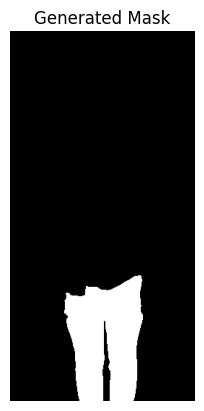

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_full/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_full/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.29182392]
Saved edited result to example_output2.png


In [127]:
main()

# Iterate over text prompt for same image

In [46]:
text_prompts = [
    'blue upper clothing',
    'purple shirt',
    'blue denim lower clothing',
    'white pants',
    'floral shirt',
    'grey cotton sweatpants'
]

In [48]:
# Iterate over each text prompt
for text_prompt in text_prompts:
    # Update the text prompt in the options dictionary
    options_dict["text_prompt"] = text_prompt
    options_dict["output_path"] = f"../{text_prompt.replace(' ', '_')}_output.png"  # Save with a unique name

    # Call the main function
    print(f"Processing text prompt: {text_prompt}")
    main()

Processing text prompt: blue upper clothing
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_full/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_full/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.30590147]
Saved edited result to ../blue_upper_clothing_output.png
Processing text prompt: purple shirt
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_full/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_full/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.30381265]
Saved edited result to ../purple_shirt_output.png
Processing text prompt: blue denim lower clothing
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): Batc

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_full/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_full/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.30811357]
Saved edited result to ../blue_denim_lower_clothing_output.png
Processing text prompt: white pants
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): Batch

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_full/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_full/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.30131274]
Saved edited result to ../white_pants_output.png
Processing text prompt: floral shirt
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, e

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_full/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_full/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.26972473]
Saved edited result to ../floral_shirt_output.png
Processing text prompt: grey cotton sweatpants
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNo

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_full/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_full/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.26925653]
Saved edited result to ../grey_cotton_sweatpants_output.png


In [ ]:
#clip score avg: 
sum = .31+.3+.31+.3+.27+.27
total = 6

0.29333333333333333

# Iterate over multiple images and prompts

In [35]:
image_folder = '../test_images/'
prompts = [
    'red leather jacket',
    'blue cotton t-shirt',
    'tan jacket'
]

In [36]:

# Function to get all image paths from a folder
def get_image_paths(folder):
    """
    Get all image file paths from a folder.

    Args:
        folder (str): Path to the folder containing images.

    Returns:
        list: List of image file paths.
    """
    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(valid_extensions)]

In [37]:
def process_images_with_prompts(image_folder, prompts):
    """
    Process all images in a folder with a list of prompts.

    Args:
        image_folder (str): Path to the folder containing images.
        prompts (list): List of text prompts.

    Returns:
        None
    """
    image_paths = get_image_paths(image_folder)
    for image_path in image_paths:
        for prompt in prompts:
            # Update the options dictionary for each image and prompt
            options_dict["img_path"] = image_path
            options_dict["text_prompt"] = prompt
            options_dict["output_path"] = f"../output/{os.path.basename(image_path).split('.')[0]}_{prompt.replace(' ', '_')}_output.png"

            # Ensure the output directory exists
            os.makedirs(os.path.dirname(options_dict["output_path"]), exist_ok=True)

            # Call the main function
            print(f"Processing image: {image_path} with prompt: '{prompt}'")
            main()



In [38]:
# Call the function to process all images with prompts
process_images_with_prompts(image_folder, prompts)

Processing image: ../test_images/WOMEN-Pants-id_00003608-10_1_front.png with prompt: 'red leather jacket'
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_10000/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_10000/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_10000/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_10000/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.2747423]
Saved edited result to ../output/WOMEN-Pants-id_00003608-10_1_front_red_leather_jacket_output.png
Processing image: ../test_images/WOMEN-Pants-id_00003608-10_1_front.png with prompt: 'blue cotton t-shirt'
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): Co

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_10000/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_10000/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_10000/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_10000/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.25690812]
Saved edited result to ../output/WOMEN-Pants-id_00003608-10_1_front_blue_cotton_t-shirt_output.png
Processing image: ../test_images/WOMEN-Pants-id_00003608-10_1_front.png with prompt: 'tan jacket'
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModul

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_10000/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_10000/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_10000/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_10000/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.25015134]
Saved edited result to ../output/WOMEN-Pants-id_00003608-10_1_front_tan_jacket_output.png
Processing image: ../test_images/MEN-Denim-id_00005208-01_7_additional.png with prompt: 'red leather jacket'
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvMod

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_10000/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_10000/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_10000/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_10000/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.28986913]
Saved edited result to ../output/MEN-Denim-id_00005208-01_7_additional_red_leather_jacket_output.png
Processing image: ../test_images/MEN-Denim-id_00005208-01_7_additional.png with prompt: 'blue cotton t-shirt'
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_10000/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_10000/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_10000/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_10000/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.25226337]
Saved edited result to ../output/MEN-Denim-id_00005208-01_7_additional_blue_cotton_t-shirt_output.png
Processing image: ../test_images/MEN-Denim-id_00005208-01_7_additional.png with prompt: 'tan jacket'
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): Con

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_10000/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_10000/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_10000/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_10000/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.24363872]
Saved edited result to ../output/MEN-Denim-id_00005208-01_7_additional_tan_jacket_output.png
Processing image: ../test_images/MEN-Jackets_Vests-id_00004319-03_4_full.png with prompt: 'red leather jacket'
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): Co

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_10000/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_10000/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_10000/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_10000/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.28157932]
Saved edited result to ../output/MEN-Jackets_Vests-id_00004319-03_4_full_red_leather_jacket_output.png
Processing image: ../test_images/MEN-Jackets_Vests-id_00004319-03_4_full.png with prompt: 'blue cotton t-shirt'
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_10000/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_10000/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_10000/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_10000/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.26868492]
Saved edited result to ../output/MEN-Jackets_Vests-id_00004319-03_4_full_blue_cotton_t-shirt_output.png
Processing image: ../test_images/MEN-Jackets_Vests-id_00004319-03_4_full.png with prompt: 'tan jacket'
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1):

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_10000/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_10000/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_10000/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_10000/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.24453641]
Saved edited result to ../output/MEN-Jackets_Vests-id_00004319-03_4_full_tan_jacket_output.png


# Iterate over images, one prompt per image

In [52]:
def process_images_with_one_prompt(image_prompt_pairs, output_folder):
    """
    Process each image with its corresponding prompt.

    Args:
        image_prompt_pairs (list): A list of tuples where each tuple contains:
                                   - image_path (str): Path to the image.
                                   - prompt (str): The text prompt for the image.

    Returns:
        None
    """
    for image_path, prompt in image_prompt_pairs:
        # Update the options dictionary for the current image and prompt
        options_dict["img_path"] = image_path
        options_dict["text_prompt"] = prompt
        options_dict["output_path"] = f"../{output_folder}/{os.path.basename(image_path).split('.')[0]}_{prompt.replace(' ', '_')}_output.png"

        # Ensure the output directory exists
        os.makedirs(os.path.dirname(options_dict["output_path"]), exist_ok=True)

        # Call the main function
        print(f"Processing image: {image_path} with prompt: '{prompt}'")
        main()

## run through test images

In [55]:
# folder and prompts
image_folder = "../test_images/"
prompts = [
    "dark red leather jacket",
    "blue cotton t-shirt",
    'green shorts',
    "gray denim pants",
    'purple upper clothing',
    'white dress',
    'striped shirt'
]

# Get all image paths in abc order
def get_image_paths(folder):
    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")
    return sorted(
        [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(valid_extensions)]
    )
image_paths = get_image_paths(image_folder)

# Pair each image with a prompt (ensure the lengths match)
image_prompt_pairs = list(zip(image_paths, prompts))

#output folder
output = 'output'

# Process each image with its corresponding prompt
process_images_with_one_prompt(image_prompt_pairs, output)

Processing image: ../test_images/MEN-Denim-id_00005208-01_7_additional.png with prompt: 'dark red leather jacket'
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_full/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_full/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.29560393]
Saved edited result to ../output/MEN-Denim-id_00005208-01_7_additional_dark_red_leather_jacket_output.png
Processing image: ../test_images/MEN-Jackets_Vests-id_00004319-03_4_full.png with prompt: 'blue cotton t-shirt'
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_full/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_full/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.25876188]
Saved edited result to ../output/MEN-Jackets_Vests-id_00004319-03_4_full_blue_cotton_t-shirt_output.png
Processing image: ../test_images/MEN-Shorts-id_00000989-01_1_front.png with prompt: 'green shorts'
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): Con

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_full/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_full/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.29091728]
Saved edited result to ../output/MEN-Shorts-id_00000989-01_1_front_green_shorts_output.png
Processing image: ../test_images/WOMEN-Blouses_Shirts-id_00000108-03_7_additional.png with prompt: 'gray denim pants'
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_full/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_full/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.30151582]
Saved edited result to ../output/WOMEN-Blouses_Shirts-id_00000108-03_7_additional_gray_denim_pants_output.png
Processing image: ../test_images/WOMEN-Blouses_Shirts-id_00003914-05_4_full.png with prompt: 'purple upper clothing'
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode=

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_full/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_full/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.28155595]
Saved edited result to ../output/WOMEN-Blouses_Shirts-id_00003914-05_4_full_purple_upper_clothing_output.png
Processing image: ../test_images/WOMEN-Dresses-id_00002326-04_4_full.png with prompt: 'white dress'
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_full/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_full/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.26985812]
Saved edited result to ../output/WOMEN-Dresses-id_00002326-04_4_full_white_dress_output.png
Processing image: ../test_images/WOMEN-Pants-id_00003608-10_1_front.png with prompt: 'striped shirt'
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
 

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_full/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_full/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.24639778]
Saved edited result to ../output/WOMEN-Pants-id_00003608-10_1_front_striped_shirt_output.png


In [ ]:
#clip avg
sum2 = .3 +.27+.29+.3+.28+.27 +.24
total2 = 7


0.2785714285714286

## experiment with vauge descriptions

In [59]:
# folder and prompts
image_folder = "../test_images/"
prompts = [
    "stylish jacket",
    "cute t-shirt",
    'fun shorts',
    "dark lower clothing",
    'stylish upper clothing',
    'light dress',
    'crazy shirt'
]

# Get all image paths in abc order
def get_image_paths(folder):
    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")
    return sorted(
        [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(valid_extensions)]
    )
image_paths = get_image_paths(image_folder)

# Pair each image with a prompt (ensure the lengths match)
image_prompt_pairs = list(zip(image_paths, prompts))

#output folder
output_vauge = 'output_vauge'

# Process each image with its corresponding prompt
process_images_with_one_prompt(image_prompt_pairs, output_vauge)

Processing image: ../test_images/MEN-Denim-id_00005208-01_7_additional.png with prompt: 'stylish jacket'
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_full/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_full/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.24936458]
Saved edited result to ../output_vauge/MEN-Denim-id_00005208-01_7_additional_stylish_jacket_output.png
Processing image: ../test_images/MEN-Jackets_Vests-id_00004319-03_4_full.png with prompt: 'cute t-shirt'
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_full/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_full/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.22864878]
Saved edited result to ../output_vauge/MEN-Jackets_Vests-id_00004319-03_4_full_cute_t-shirt_output.png
Processing image: ../test_images/MEN-Shorts-id_00000989-01_1_front.png with prompt: 'fun shorts'
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvMo

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_full/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_full/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.27801916]
Saved edited result to ../output_vauge/MEN-Shorts-id_00000989-01_1_front_fun_shorts_output.png
Processing image: ../test_images/WOMEN-Blouses_Shirts-id_00000108-03_7_additional.png with prompt: 'dark lower clothing'
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_full/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_full/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.27214226]
Saved edited result to ../output_vauge/WOMEN-Blouses_Shirts-id_00000108-03_7_additional_dark_lower_clothing_output.png
Processing image: ../test_images/WOMEN-Blouses_Shirts-id_00003914-05_4_full.png with prompt: 'stylish upper clothing'
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_full/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_full/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.25115824]
Saved edited result to ../output_vauge/WOMEN-Blouses_Shirts-id_00003914-05_4_full_stylish_upper_clothing_output.png
Processing image: ../test_images/WOMEN-Dresses-id_00002326-04_4_full.png with prompt: 'light dress'
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_full/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_full/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.2876626]
Saved edited result to ../output_vauge/WOMEN-Dresses-id_00002326-04_4_full_light_dress_output.png
Processing image: ../test_images/WOMEN-Pants-id_00003608-10_1_front.png with prompt: 'crazy shirt'
export CUDA_VISIBLE_DEVICES=0
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=128, out_channels=64
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
)
Building UpConvBlock with upsample_cfg: {'type': 'InterpConv'}
Initializing InterpConv with in_channels=256, out_channels=128
Upsample layer built: InterpConv(
  (interp_upsample): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): ConvModule

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch ../fashion-model-finetuned_full/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch ../fashion-model-finetuned_full/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../fashion-model-finetuned_full/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

CLIP Score: [0.21370217]
Saved edited result to ../output_vauge/WOMEN-Pants-id_00003608-10_1_front_crazy_shirt_output.png


In [60]:
#clip avg
sum3 = .25+.23+.28+.27+.25+.29+.21
total3 = 7

In [61]:
#total clip avg from experiments
(sum+sum2+sum3)/ (total+total2+total3)

0.2745

# calculate FID

In [ ]:
import torch
import numpy as np
from scipy.linalg import sqrtm
from torchvision.models import inception_v3
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torch.utils.data import DataLoader
from PIL import Image

# Preprocessing for InceptionV3
def preprocess_image(image, image_size=299):
    transform = Compose([
        Resize((image_size, image_size)),
        CenterCrop(image_size),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(image).unsqueeze(0)

# Extract features using InceptionV3
def get_features(images, model, device):
    model.eval()
    features = []
    with torch.no_grad():
        for img_path in images:
            # Open the image file
            img = Image.open(img_path).convert("RGB")  # Ensure it's in RGB format
            img = preprocess_image(img).to(device)
            feature = model(img)[0].cpu().numpy()
            features.append(feature)
    return np.array(features)

# Calculate FID
def calculate_fid(real_features, generated_features):
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)

    # Compute mean and covariance differences
    diff = mu1 - mu2
    covmean, _ = sqrtm(sigma1 @ sigma2, disp=False)

    # Numerical stability
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

# Example usage
if __name__ == "__main__":
    # Load InceptionV3 model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inception = inception_v3(pretrained=True, transform_input=False).to(device)
    inception.fc = torch.nn.Identity()  # Remove the classification head

    # Load real and generated image
    real_images = get_image_paths(image_folder)
    generated_images = get_image_paths('../output')

    # Extract features
    real_features = get_features(real_images, inception, device)
    generated_features = get_features(generated_images, inception, device)

    # Calculate FID
    fid_score = calculate_fid(real_features, generated_features)
    print(f"FID Score: {fid_score}")

    

FID Score: 76.09522089627106


In [91]:
from PIL import Image

# Image resizing

In [93]:
img = Image.open('../test_images/WOMEN-Dresses-id_00002326-04_4_full.png')
width, height = img.size
print(width, height)

512 1024


In [104]:
img = Image.open('../ash.jpg')
width, height = img.size
print(width, height)

980 1961


In [105]:
resized_im = img.resize((512,1024))

In [106]:
resized_im.save('../resized_ash.png', format= 'PNG')